In [1]:
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import erfc
from  math import log10, sqrt

In [2]:
#%% Parameters

k = 4
n = 2
M = 2**k
R = k/n

#nb = 2  #nb bits/symboles (pour comparer avec différentes modulations)

In [3]:
class Normalization2(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self,x):
            y = torch.flatten(x)
            #m = torch.mean(y)
            #s = torch.std(y)
            s = torch.sqrt(torch.mean(y**2))
            x  = x/(sqrt(2)*s)
            
            #print((torch.sqrt(torch.mean(torch.flatten(x)**2))))
            return x

#%% NN
class Normalization(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self,x):
            x = np.sqrt(x.size()[1])*x/(torch.norm(x,dim=1,p=2,keepdim=True))
            return x

class Net(nn.Module):
    def __init__(self, Es_N0_dB):
        super(Net, self).__init__()
        
        self.layer_Relu = nn.Linear(M,M)
        self.layer_linear = nn.Linear(M,n)
        self.set_sigma(Es_N0_dB)

        self.decoder = torch.nn.Sequential(
            nn.Linear(n,M),
            nn.ReLU(),
            nn.Linear(M,M)
        )        

    def encoder(self,x):
        x = torch.relu(self.layer_Relu(x))
        x = self.layer_linear(x)
        
        # Calcule la moyenne et la variance sur tout le codebook
        C = torch.relu(self.layer_Relu(torch.eye(M)))
        C = self.layer_linear(C)
        m = torch.mean(torch.flatten(C))
        s = sqrt(2)*torch.std(torch.flatten(C))
        
        x = (x - m)/s
        return x


        # self.encoder = torch.nn.Sequential(
        #     nn.Linear(M,M),
        #     nn.ReLU(),
        #     nn.Linear(M,n),
        #     Normalization2()
        # )

    def set_sigma(self, Es_N0_dB):
        self.sigma = (1/np.sqrt(2*10**(Es_N0_dB/10)))

    def forward(self,x):
        x = self.encoder(x)
        x = self.channel(x)
        x = self.decoder(x)
        return x

    def channel(self,x):
        sampled_noise = self.sigma*torch.randn(x.size())
        x += sampled_noise
        return x
        
def generate_data(M,batch_size):
    s = np.random.randint(M,size=(batch_size),dtype=np.int64)
    data = torch.zeros([batch_size,M])
    for i in range(batch_size):
        data[i][s[i]]=1
    return data,torch.from_numpy(s)

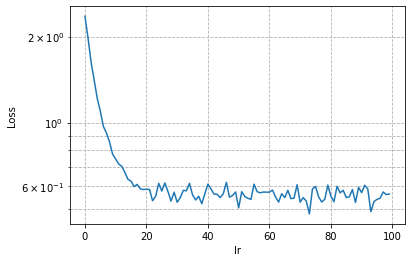

In [4]:
#%% Choosing lr
Eb_N0_dB_train = 7
Es_N0_dB_train = Eb_N0_dB_train + 10*log10(R)
net = Net(Es_N0_dB_train)

n_epochs= 100
batch_size = 1000
const_list = []

Loss = torch.zeros(n_epochs)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
for i in range(n_epochs):
    for j in range(100):
        input_data, label = generate_data(M,batch_size)
        output = net(input_data)
        # Backpropagate gradient
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    Const = net.encoder(torch.eye(M))
    const_list.append(Const)
    Loss[i]=loss

        
Loss_tr = Loss.detach().numpy()
plt.figure()
plt.plot(Loss_tr)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("lr")
plt.grid(True,which="both", linestyle='--')
plt.show()

In [5]:
torch.save(const_list,'const_avg_pow.pt')

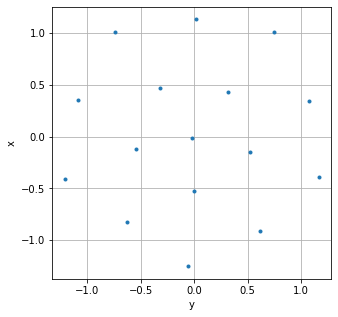

In [6]:
constellation= np.array(())
for m in range(M):
    input_data = torch.zeros([1,M]) #Hot vector
    input_data[0][m]= 1
    c = net.encoder(input_data)

    constellation = np.concatenate((constellation, c.detach().numpy()[0,:]),axis=0)
plt.figure(figsize = (5, 5))
plt.ylabel("x")
plt.xlabel("y")
plt.plot(constellation[0::2],constellation[1::2],'.')
plt.grid()
plt.show()


(array([1., 2., 0., 0., 0., 0., 4., 0., 1., 0., 0., 1., 2., 2., 0., 0., 0.,
        1., 1., 1.]),
 array([-1.1556133 , -1.03899134, -0.92236937, -0.80574741, -0.68912544,
        -0.57250348, -0.45588151, -0.33925955, -0.22263758, -0.10601562,
         0.01060635,  0.12722831,  0.24385028,  0.36047224,  0.47709421,
         0.59371617,  0.71033814,  0.8269601 ,  0.94358207,  1.06020404,
         1.176826  ]),
 <BarContainer object of 20 artists>)

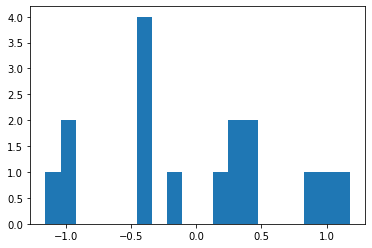

In [10]:
plt.hist(constellation[0::2],20)